# Run clustering and write to file

In [1]:
#add the aare build folder to sys.path to make it visible to python
import sys
sys.path.append('/home/l_msdetect/erik/aare/build')

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import time

#Directly import what we need from aare
from aare import File, ClusterFileSink, ClusterFinderMT, ClusterFile, hitmap


base = Path('/mnt/sls_det_storage/highZ_data/Erik/CZT_Mo')
out_fname = base/'processed/Mo.clust'

## Pedestal

In [2]:
n_frames_pd = 1000
cluster_size = (3,3)
image_size = (256,256) #could also be read from master file
pedestal_file = base/'20241212_CZTsolo_Pedestal_Tp_15C_tint_100_period_0910us_master_0.json'
data_file = base/'20241212_CZTsolo_Xray_Tp_15C_tint_100_period_0910us_master_0.json'

cf = ClusterFinderMT(image_size, cluster_size, n_sigma = 10, capacity = 2000, n_threads=48)

t0 = time.perf_counter()

with File(pedestal_file) as f:
    for i in range(n_frames_pd):
        img = f.read_frame()
        cf.push_pedestal_frame(img)
        
cf.sync() #Wait until the input queue is empty, purely for timing
elapsed_t = time.perf_counter()-t0
print(f'Pedestal took: {elapsed_t:.3f}s')

Pedestal took: 1.060s


# Clustering

In [3]:
N = 50000
t_start = time.perf_counter()
t0 = time.perf_counter()

#Connect a sink to the ClusterFinder, this will pull all clustered frames
#from the ClusterFinder and write them to a old style cluster file
sink = ClusterFileSink(cf, out_fname)

with File(data_file) as f:
    f.seek(500) #skip the first 500 frames to avoid temperature issues
    for i in range(N):
        frame_number = f.frame_number()
        frame = f.read_frame()
        cf.find_clusters(frame, frame_number)

cf.stop()
sink.stop()
t_elapsed = time.perf_counter()-t0
print(f'Clustering (and writing to disk) {N} frames took {t_elapsed:.2f}s  {N/t_elapsed:.0f} FPS')


Clustering (and writing to disk) 50000 frames took 3.03s  16515 FPS


## Plot the results

- Load data from the cluster file
- Iterate over the file
- Fill the histogram with the sum of the cluster

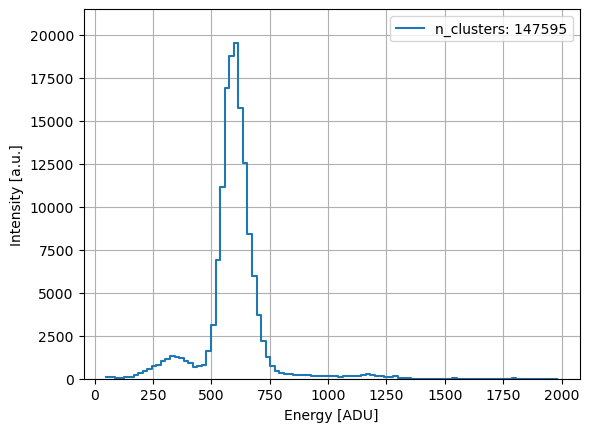

In [4]:
with ClusterFile(out_fname) as f:
    hist1 = bh.Histogram(bh.axis.Regular(100, 50, 2000))
    for clusters in f:
        hist1.fill(clusters.sum())
        

fig, ax = plt.subplots()
ax.step(hist1.axes[0].edges[:-1], hist1.values(), where="post", label = f'n_clusters: {hist1.sum():.0f}');
ax.set_xlabel('Energy [ADU]')
ax.set_ylabel('Intensity [a.u.]')
ax.legend()
ax.set_ylim(0, hist1.values().max()*1.1)
ax.grid()

### Make an hitmap from all frames

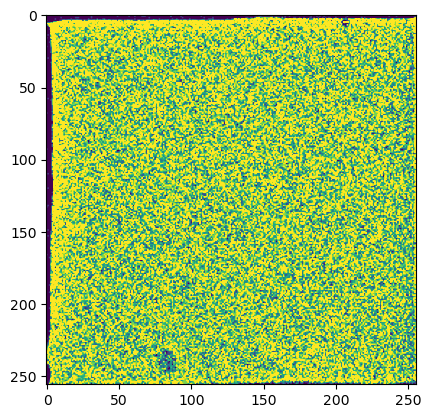

In [5]:
img = np.zeros((256,256))
with ClusterFile(out_fname) as f:
    for i in range(1000):
        clusters = f.read_frame()
        img += hitmap(img.shape, clusters)
        
fig, ax = plt.subplots()
im = ax.imshow(img)
im.set_clim(0,5)

### Clusters per frame

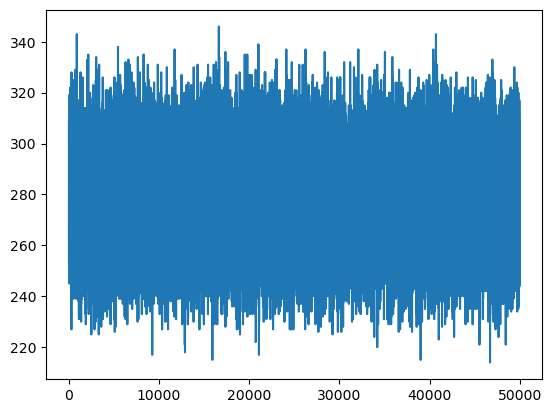

In [6]:
clusters_per_frame = np.zeros(N)
frame_numbers = np.zeros(N)
img = np.zeros((256,256))
with ClusterFile(out_fname) as f:
    for i in range(N):
        clusters = f.read_frame()
        clusters_per_frame[i] = clusters.size
        frame_numbers[i] = clusters.frame_number
        

fig, ax = plt.subplots()
ax.plot(clusters_per_frame[frame_numbers.argsort()])